In [ ]:
import pandas as pd
import pickle
import random
import os
import time
import numpy as np
import requests
from dotenv import load_dotenv

from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss

import torch

load_dotenv()

data = load_dataset("sentence-transformers/squad", split="train")

model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
reranker_model = CrossEncoder("cross-encoder/ms-marco-TinyBERT-L-2-v2", max_length=512)
api_key = os.getenv("CLARIN_API_KEY")

In [ ]:
data = data.filter(
    lambda row, unique=set(): not (row["answer"] in unique or unique.add(row["answer"]))
)
data

Dataset({
    features: ['question', 'answer'],
    num_rows: 18891
})

In [3]:
questions = data["question"]
answers = data["answer"]

In [ ]:
if not os.path.exists("../data/answer_embeddings.pt"):
    answer_embeddings = model.encode(
        answers, convert_to_tensor=True, batch_size=64, show_progress_bar=True
    )
    torch.save(answer_embeddings, "../data/answer_embeddings.pt")
else:
    answer_embeddings = torch.load("../data/answer_embeddings.pt", weights_only=True)

if not os.path.exists("../data/question_embeddings.pt"):
    question_embeddings = model.encode(
        questions, convert_to_tensor=True, batch_size=64, show_progress_bar=True
    )
    torch.save(question_embeddings, "../data/question_embeddings.pt")
else:
    question_embeddings = torch.load("../data/question_embeddings.pt", weights_only=True)

In [10]:
def search_query_top_k(query, corpus_embedding, corpus, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    cosine_scores = model.similarity(query_embedding, corpus_embedding)[0]
    scores, indices = torch.topk(cosine_scores, k=top_k)
    print("Query:", query)
    print("Top 5 answers:")
    for i, index in enumerate(indices):
        print(f"\t{i+1}) {corpus[index]}")
        print("Cosine similarity score:", scores[i].item())
        print()

In [11]:
random_question = random.choice(questions)
search_query_top_k(random_question, answer_embeddings, answers, top_k=5)

Query: What retired NASA Office of inspector general is outspoken about the FAA?
Top 5 answers:
	1) The FAA has been cited as an example of regulatory capture, "in which the airline industry openly dictates to its regulators its governing rules, arranging for not only beneficial regulation, but placing key people to head these regulators." Retired NASA Office of Inspector General Senior Special Agent Joseph Gutheinz, who used to be a Special Agent with the Office of Inspector General for the Department of Transportation and with FAA Security, is one of the most outspoken critics of FAA. Rather than commend the agency for proposing a $10.2 million fine against Southwest Airlines for its failure to conduct mandatory inspections in 2008, he was quoted as saying the following in an Associated Press story: "Penalties against airlines that violate FAA directives should be stiffer. At $25,000 per violation, Gutheinz said, airlines can justify rolling the dice and taking the chance on getting 

In [12]:
def normalize(embeddings):
    return embeddings / np.linalg.norm(embeddings, axis=0, keepdims=True)

In [ ]:
if not os.path.exists("../data/answers_dataset.pt"):
    answers_dataset = Dataset.from_dict(
        {"answers": data["answer"], "embeddings": answer_embeddings.cpu().numpy()}
    )
    answers_dataset = answers_dataset.map(lambda x: {"embeddings": normalize(x["embeddings"])})

    answers_dataset = answers_dataset.add_faiss_index(
        column="embeddings", metric_type=faiss.METRIC_INNER_PRODUCT
    )
    answers_dataset.save_faiss_index("embeddings", "../data/answer_embeddings_faiss")
    torch.save(answers_dataset, "../data/answers_dataset.pt")
else:
    answers_dataset = torch.load("../data/answers_dataset.pt", weights_only=False)
    answers_dataset.load_faiss_index("embeddings", "../data/answer_embeddings_faiss")

In [ ]:
if not os.path.exists("../data/questions_dataset.pt"):
    questions_dataset = Dataset.from_dict(
        {"questions": data["question"], "embeddings": question_embeddings.cpu().numpy()}
    )
    questions_dataset = questions_dataset.map(lambda x: {"embeddings": normalize(x["embeddings"])})

    questions_dataset = questions_dataset.add_faiss_index(
        column="embeddings", metric_type=faiss.METRIC_INNER_PRODUCT
    )
    questions_dataset.save_faiss_index("embeddings", "../data/question_embeddings_faiss")
    torch.save(questions_dataset, "../data/questions_dataset.pt")
else:
    questions_dataset = torch.load("../data/questions_dataset.pt", weights_only=False)
    answers_dataset.load_faiss_index("embeddings", "../data/question_embeddings_faiss")

In [ ]:
def search_query_top_k_faiss(query, answers_ds, corpus, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=False)
    query_embedding = normalize(query_embedding)

    scores, samples = answers_ds.get_nearest_examples("embeddings", query_embedding, k=top_k)
    samples_df = pd.DataFrame.from_dict(samples)
    samples_df["scores"] = scores
    samples_df.sort_values("scores", ascending=False, inplace=True)

    print("Query:", query)
    print("Top 5 answers:")
    for i, row in samples_df.iterrows():
        print(f"\t{i+1}) {row['answers']}")
        print("Cosine similarity score:", row["scores"])
        print()

In [33]:
search_query_top_k_faiss(questions[0], answers_dataset, answers, top_k=5)

Query: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Top 5 answers:
	1) Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Cosine similarity score: 1.0

	2) The Gospel of Luke begins its account of Mary's life with the Annunciation, when the angel Gabriel appeared to her and announced her divine selection to be the mother of Je

In [34]:
random_question = random.choice(questions)
search_query_top_k_faiss(random_question, answers_dataset, answers, top_k=5)

Query: At what New Haven museum is an original copy of the Gutenberg Bible housed?
Top 5 answers:
	1) New Haven has a variety of museums, many of them associated with Yale. The Beinecke Rare Book and Manuscript Library features an original copy of the Gutenberg Bible. There is also the Connecticut Children's Museum; the Knights of Columbus museum near that organization's world headquarters; the Peabody Museum of Natural History; the Yale University Collection of Musical Instruments; the Eli Whitney Museum (across the town line in Hamden, Connecticut, on Whitney Avenue); the Yale Center for British Art, which houses the largest collection of British art outside the U.K., and the Yale University Art Gallery, the nation's oldest college art museum.[citation needed] New Haven is also home to the New Haven Museum and Historical Society on Whitney Avenue, which has a library of many primary source treasures dating from Colonial times to the present.
Cosine similarity score: 1.0

	2) Grove St

In [ ]:
def search(
    query: str,
    answer_embeddings,
    answers_dataset,
    top_k: int = 5,
    faiss: bool = False,
    answers_key: str = "answers",
):
    query_embedding = model.encode(query, convert_to_tensor=False)

    if faiss:
        scores, samples = answers_dataset.get_nearest_examples(
            "embeddings", query_embedding, k=top_k
        )
        retrieved_indices = [
            answers_dataset[answers_key].index(answer) for answer in samples[answers_key]
        ]
    else:
        cosine_scores = model.similarity(query_embedding, answer_embeddings.cpu())[0]
        scores, indices = torch.topk(cosine_scores, k=top_k)
        retrieved_indices = indices.tolist()

    return scores, retrieved_indices

In [ ]:
def calculate_recall(relevant_index, retrieved_indices):
    recall = 1 if relevant_index in retrieved_indices else 0
    return recall

In [49]:
subset_questions = questions[:1000]
recall_cosine_search = []
recall_faiss_search = []

In [ ]:
start_time = time.time()
for query in subset_questions:
    relevant_index = questions.index(query)
    scores, retrieved_indices = search(
        query, answer_embeddings, answers_dataset, top_k=5, faiss=False
    )
    recall_cosine_search.append(calculate_recall(relevant_index, retrieved_indices))
average_recall_semantic_search = sum(recall_cosine_search) / len(recall_cosine_search)
end_time = time.time()

print(
    "Average Recall (Cosine Search):",
    average_recall_semantic_search,
    "Time taken:",
    end_time - start_time,
)

Average Recall (Cosine Search): 0.913 Time taken: 20.993836402893066


In [ ]:
start_time = time.time()
for query in subset_questions:
    relevant_index = questions.index(query)
    scores, retrieved_indices = search(
        query, answer_embeddings, answers_dataset, top_k=5, faiss=True
    )
    recall_faiss_search.append(calculate_recall(relevant_index, retrieved_indices))
average_recall_faiss_search = sum(recall_faiss_search) / len(recall_faiss_search)
end_time = time.time()

print(
    "Average Recall (Faiss Search):",
    average_recall_faiss_search,
    "Time taken:",
    end_time - start_time,
)

Average Recall (Faiss Search): 1.0 Time taken: 178.97983503341675


In [ ]:
def calculate_mrr(queries, questions, answer_embeddings, top_k=5, faiss=False):
    mrr_total = 0.0

    for query in queries:
        relevant_index = questions.index(query)
        _, retrieved_indices = search(
            query, answer_embeddings, answers_dataset, top_k=top_k, faiss=faiss
        )

        if relevant_index in retrieved_indices:
            rank = retrieved_indices.index(relevant_index) + 1
            reciprocal_rank = 1 / rank
        else:
            reciprocal_rank = 0

        mrr_total += reciprocal_rank

    mrr = mrr_total / len(queries)
    return mrr


start_time = time.time()
mrr = calculate_mrr(subset_questions, questions, answer_embeddings, top_k=5)
end_time = time.time()
print("Mean Reciprocal Rank (MRR):", mrr, "Time taken:", end_time - start_time)

start_time = time.time()
mrr_faiss = calculate_mrr(subset_questions, questions, answers_dataset, top_k=5, faiss=True)
end_time = time.time()
print("Mean Reciprocal Rank (MRR) using FAISS:", mrr_faiss, "Time taken:", end_time - start_time)

Mean Reciprocal Rank (MRR): 0.7784666666666672 Time taken: 21.9837327003479
Mean Reciprocal Rank (MRR) using FAISS: 0.9985 Time taken: 180.64294600486755


In [ ]:
def rerank(query, retrieved_indices, corpus, verbose=False):
    retrieved_answers = [corpus[idx] for idx in retrieved_indices]

    pairs = [(query, answer) for answer in retrieved_answers]

    reranked_scores = reranker_model.predict(pairs)
    sort_indices = np.argsort(reranked_scores)[::-1]
    reranked_indices = [retrieved_indices[i] for i in sort_indices]

    if verbose:
        print("Query:", query)
        print("Top 5 answers after reranking:")
        for i, index in enumerate(reranked_indices):
            print(f"\t{i+1}) {corpus[index]}")
            print("Reranked score:", reranked_scores[sort_indices[i]])
            print()

    return reranked_scores, reranked_indices

## RERANK WITHOUT FAISS

In [ ]:
scores, retrieved_indices = search(
    questions[0], answer_embeddings, answers_dataset, top_k=5, faiss=False
)

rerank(questions[0], retrieved_indices, answers, verbose=True)

Query: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Top 5 answers after reranking:
	1) Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Reranked score: -1.5392361

	2) Henry VII added a Perpendicular style chapel dedicated to the Blessed Virgin Mary in 1503 (known as the Henry VII Chapel or the "Lady Chapel"). Much of the st

## RERANK WITH FAISS

In [ ]:
scores, retrieved_indices = search(
    questions[0], answer_embeddings, answers_dataset, top_k=5, faiss=True
)

rerank(questions[0], retrieved_indices, answers, verbose=True)

Query: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Top 5 answers after reranking:
	1) Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Reranked score: -1.5392375

	2) Some Western writers claim that the immaculate conception of Mary is a teaching of Islam. Thus, commenting in 1734 on the passage in the Qur'an, "I have calle

In [ ]:
recall_rerank_cosine_search = []
recall_rerank_faiss_search = []

for query in subset_questions:
    relevant_index = questions.index(query)

    scores, retrieved_indices = search(
        query, answer_embeddings, answers_dataset, top_k=5, faiss=False
    )
    reranked_scores, reranked_indices = rerank(query, retrieved_indices, answers)
    recall_rerank_cosine_search.append(calculate_recall(relevant_index, reranked_indices))

    scores, retrieved_indices = search(
        query, answer_embeddings, answers_dataset, top_k=5, faiss=True
    )
    reranked_scores, reranked_indices = rerank(query, retrieved_indices, answers)
    recall_rerank_faiss_search.append(calculate_recall(relevant_index, reranked_indices))

average_recall_rerank_cosine_search = sum(recall_rerank_cosine_search) / len(
    recall_rerank_cosine_search
)
average_recall_rerank_faiss_search = sum(recall_rerank_faiss_search) / len(
    recall_rerank_faiss_search
)

print("Average Recall with Reranking (Cosine Search):", average_recall_rerank_cosine_search)
print("Average Recall with Reranking (FAISS Search):", average_recall_rerank_faiss_search)

Average Recall with Reranking (Cosine Search): 0.913
Average Recall with Reranking (FAISS Search): 1.0


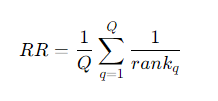

In [69]:
def calculate_mrr_rerank(queries, questions, answer_embeddings, top_k=5, faiss=False):
    mrr_total = 0.0

    for query in queries:
        relevant_index = questions.index(query)
        _, retrieved_indices = search(
            query, answer_embeddings, answers_dataset, top_k=top_k, faiss=faiss
        )
        _, reranked_indices = rerank(query, retrieved_indices, answers)

        if relevant_index in reranked_indices:
            rank = reranked_indices.index(relevant_index) + 1
            reciprocal_rank = 1 / rank
        else:
            reciprocal_rank = 0

        mrr_total += reciprocal_rank

    mrr = mrr_total / len(queries)
    return mrr


mrr_rerank_semantic_search = calculate_mrr_rerank(
    subset_questions, questions, answer_embeddings, top_k=5
)
print("Mean Reciprocal Rank (MRR) with Reranking (Cosine Search):", mrr_rerank_semantic_search)

mrr_rerank_faiss = calculate_mrr_rerank(
    subset_questions, questions, answer_embeddings, top_k=5, faiss=True
)
print("Mean Reciprocal Rank (MRR) with Reranking (FAISS Search):", mrr_rerank_faiss)

Mean Reciprocal Rank (MRR) with Reranking (Cosine Search): 0.8163666666666667
Mean Reciprocal Rank (MRR) with Reranking (FAISS Search): 0.9087000000000003


# PART II

In [88]:
BASE_URL = "https://services.clarin-pl.eu/api/v1/oapi"
MODELS_ENDPOINT = f"{BASE_URL}/models"
CHAT_ENDPOINT = f"{BASE_URL}/chat/completions"


headers = {"Authorization": f"Bearer {api_key}"}

response = requests.get(MODELS_ENDPOINT, headers=headers)
models = response.json()
models

{'data': [{'id': 'bielik',
   'full_name': 'speakleash/Bielik-11B-v2.2-Instruct',
   'name': 'speakleash/Bielik-11B-v2.2-Instruct'},
  {'id': 'cohere',
   'full_name': 'CohereForAI/c4ai-command-r-plus',
   'name': 'CohereForAI/c4ai-command-r-plus'},
  {'id': 'llama3.1-8b',
   'full_name': 'meta-llama/Llama-3.1-8B-Instruct',
   'name': 'meta-llama/Llama-3.1-8B-Instruct'},
  {'id': 'llama',
   'full_name': 'meta-llama/Meta-Llama-3.1-70B-Instruct',
   'name': 'meta-llama/Meta-Llama-3.1-70B-Instruct'},
  {'id': 'llama-guard',
   'full_name': 'meta-llama/Llama-Guard-3-8B',
   'name': 'meta-llama/Llama-Guard-3-8B'},
  {'id': 'llama3.1',
   'full_name': 'meta-llama/Meta-Llama-3.1-70B-Instruct',
   'name': 'meta-llama/Meta-Llama-3.1-70B-Instruct'},
  {'id': 'openchat',
   'full_name': 'openchat/openchat-3.5-1210',
   'name': 'openchat/openchat-3.5-1210'},
  {'id': 'mixtral-8x22B',
   'full_name': 'mistralai/Mixtral-8x22B-Instruct-v0.1',
   'name': 'mistralai/Mixtral-8x22B-Instruct-v0.1'}]}

In [ ]:
dataset = load_dataset("stanfordnlp/imdb")["train"]
dataset

In [ ]:
if not os.path.exists("../data/imdb_dataset.pkl"):
    dataset = dataset.map(
        lambda x: {"embeddings": normalize((model.encode(x["text"], convert_to_tensor=True)).cpu())}
    )
    dataset = dataset.add_faiss_index(column="embeddings", metric_type=faiss.METRIC_INNER_PRODUCT)
    with open("../data/imdb_dataset.pkl", "wb") as f:
        pickle.dump(dataset, f)
    dataset.save_faiss_index("embeddings", "../data/imdb_texts.faiss")
else:
    with open("../data/imdb_dataset.pkl", "rb") as f:
        dataset = pickle.load(f)

In [86]:
def generate_answer(api_token, query, rag_context=None):
    headers = {"Authorization": f"Bearer {api_token}", "Content-Type": "application/json"}

    if rag_context:
        text_context = "\n".join(rag_context)
        prompt = f"Answer the question based only on the following context:\n{text_context}\nQuestion: {query}."
    else:
        prompt = query

    data = {
        "model": "bielik",
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": 160,
        "temperature": 0.2,
    }

    response = requests.post(CHAT_ENDPOINT, headers=headers, json=data)
    return response.json()["choices"][0]["message"]["content"]

In [89]:
query = "What is the best movie of all time?"
answer = generate_answer(api_key, query)
print(f"Question: \n{query}\n")
print(f"Answer from LLM memory: \n{answer}\n")

scores, indices = search(query, dataset["embeddings"], dataset, top_k=5, faiss=True, answers_key="text")
rag_context = [dataset[idx]["text"] for idx in indices]
answer = generate_answer(api_key, query, rag_context)
print(f"Answer with RAG: \n{answer}\n")

Question: 
What is the best movie of all time?

Answer from LLM memory: 
Determining the "best" movie of all time is subjective and depends on personal preferences. However, some films like "The Godfather," "Citizen Kane," "Pulp Fiction," "Shawshank Redemption," and "The Wizard of Oz" are often cited in lists of the greatest films of all time. "Citizen Kane" frequently tops many professional rankings.

Answer with RAG: 
Based on the provided context, the best movie of all time is "Return Of The Jedi."

